We follow up on [first](./01_spin_half_Rabi_Hahn.ipynb) tutorial, but with a more concrete quantum system: the nitrogen vacancy (NV) center in diamond. NVs are the most known color centers, due to its extensive research in quantum technologies. Here, however, we will focus on QuaCCAToo's usage rather than the physics of the NV itself. For more detailed information about NVs, we recommend:

[1] E. V. Levine, et al., Principles and techniques of the quantum diamond microscope, Nanophotonics 8, 1945 (2019).

[2] S. Pezzagna and J. Meijer, Quantum computer based on color centers in diamond, Applied Physics Reviews 8,011308 (2021).

In [ ]:
import numpy as np
from lmfit import Model
import copy
from qutip import fock_dm, tensor, qeye, jmat

from quaccatoo import plot_energy_B0, NV, Rabi, Ramsey, PMR, RabiModel, fit_two_lorentz_sym, fit_two_sinc2_sym, Analysis, ExpData

# 1. Energy Levels

We begin defining the quantum system from the predefined `NV` class in quaccatoo. The class has only two mandatory parameters, the nitrogen isotope $^{14}\text{N}$, $^{15}\text{N}$ or None (which neglects all nuclear terms) and the magnetic field in mT. Optionally, the user can define a misalignment angle between the NV axis and the magnetic field, alternative magnetic field units, alternative Hamiltonian units, or collapse operators for the pulsed experiments. To visualize the energy levels, we use the `plot_energy` method.

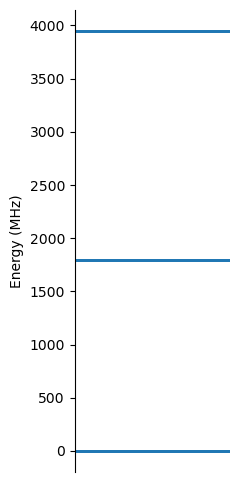

In [2]:
qsys_1 = NV(
    N=15,
    B0 = 38.4,
    units_B0='mT'    
)

qsys_1.plot_energy()

We observe the three electronic energy levels of the NV center: $m_s=0,-1,+1$. To be able to see the nuclear levels splitting, we need to specify a smaller energy range in the `plot_energy` method.

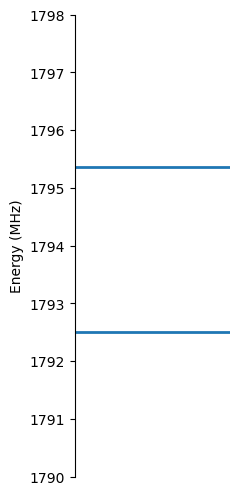

In [3]:
qsys_1.plot_energy(energy_lim=[1790, 1798])

Now, the splitting from the $^{15}\text{N}$ nuclear spin is observed.

So far we considered $B_0=38.4$ mT, but if we want to see how these energy levels change as a function of the external magnetic field, we can use the `plot_energy_B0` function.

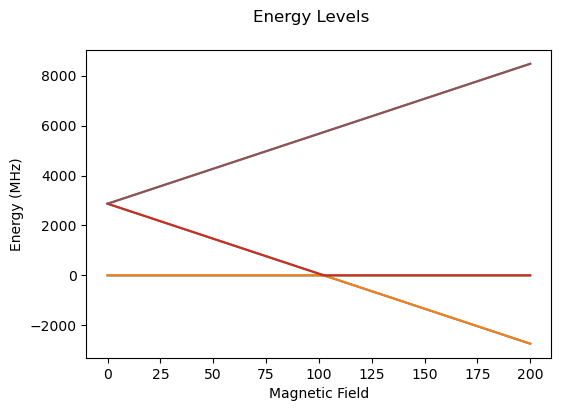

In [4]:
# range of B0 values where we want to plot the energy levels
B0_array = np.linspace(0, 200, 100)

plot_energy_B0(
    B0 = B0_array,
    # here we calculate the Hamiltonian for each B0 value
    H0 = [NV(N=15, B0=B, units_B0='mT').H0 for B in B0_array] 
)

As expected, the $m_s=+1$ grows linearly with the field, while the $m_s=-1$ decreases linearly and $m_s=0$ level is not affected by the field. After 100 mT, the level anticrossing occurs.

# 2. Rabi Oscillations of Electronic Spin

Just like in the previous notebook, the first experiment usually conducted is Rabi oscillations. In this case, $\hat{h}_1$ and the resonant frequency of the pulse are not as trivial as before. The user can define their own parameters, but the NV class has a standard interaction Hamiltonian
$$ \hat{h}_1 = \hat{S}_x \otimes \mathbb{1}, $$
which can be obtained by the `MW_h1` method. While the resonant frequencies for the $m_s=0 \rightarrow -1$ and $m_s=0 \rightarrow +1$ can be obtained from `MW_freqs` attribute, which takes the average between the two nuclear spin states. Again, we will consider a square cosine wave for the pulse.

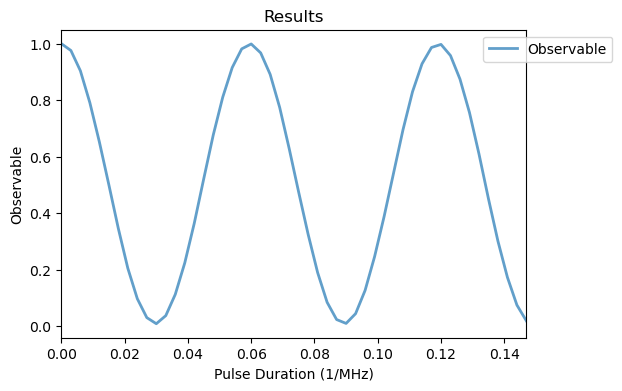

In [5]:
# typical NV Rabi frequency in MHz
w1 = 16.72 

rabi_sim_1 = Rabi(
    # pulse duration in us
    pulse_duration = np.arange(0, 0.15, 3e-3), 
    # NV center system defined above
    system = qsys_1, 
    # control Hamiltonian
    h1 = w1*qsys_1.MW_h1, 
    # MW frequency for the ms=0 --> ms=-1 state transition
    pulse_params = {'f_pulse': qsys_1.MW_freqs[0]} 
)


# run the experiment and plot results
rabi_sim_1.run()
rabi_analysis_1 = Analysis(rabi_sim_1)
rabi_analysis_1.plot_results()

If we want to compare with the simulation with experimental data, we can use the `ExpData` class to load it from .dat or .txt file and the `compare_with` method. In this case, the experimental data was measured for the same NV parameters as defined previously.

LinregressResult(slope=np.float64(2.5895433124843423), intercept=np.float64(-2.0453606037750993), rvalue=np.float64(0.9872724331132969), pvalue=np.float64(5.450830010550885e-40), stderr=np.float64(0.060209767213068484), intercept_stderr=np.float64(0.05996996938639089))

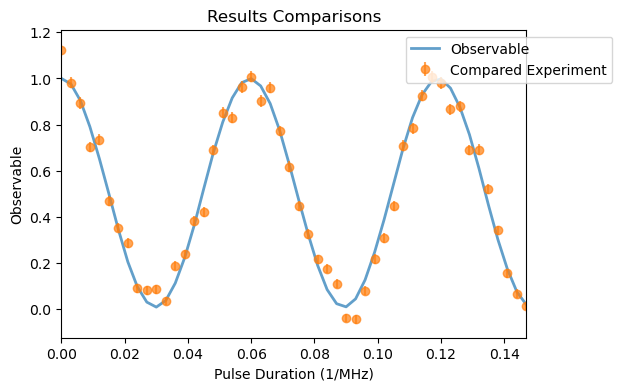

In [6]:
exp_data = ExpData(file_path='./exp_data_tutorials/Ex02_NV_rabi.dat',
                    variable_column=0,
                    results_columns=1,
                    yerr_columns=2
                   )
# convert the variable from s to us
exp_data.variable *= 1e6 

rabi_analysis_1.compare_with(exp_data)
rabi_analysis_1.plot_comparison()
rabi_analysis_1.pearson

We observe a strong correlation of the simulation and experimental data with an rvalue of 0.987. The standard observable for the NV is the population in the $m_s=0$ given by the fluorescence. To see the populations of the other two states $m_s=\pm 1$, we need to redefine the system observables and run again the Rabi experiment.

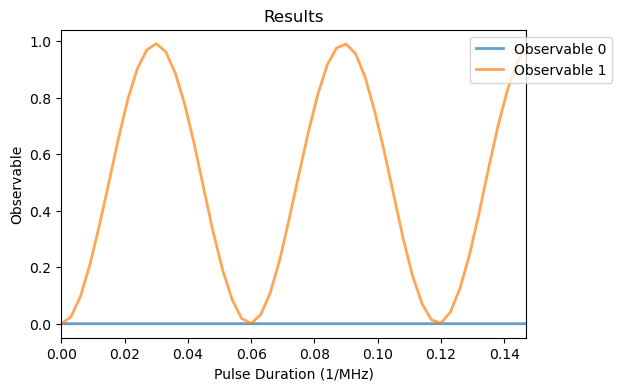

In [7]:
qsys_1.observable = [tensor(fock_dm(3, 0), qeye(2)), tensor(fock_dm(3, 2), qeye(2))]

# run the experiment
rabi_sim_1.run()
Analysis(rabi_sim_1).plot_results()

Note that population of the $m_s=+1$ remains 0, as we are using the $m_s=0 \rightarrow -1$ resonant frequency, while the $m_s=-1$ population oscillates with the same frequency as the $m_s=0$ population, but with opposite sign. If we used the other resonant frequency, the $m_s=+1$ population would oscillate but $m_s=-1$ would remain 0.

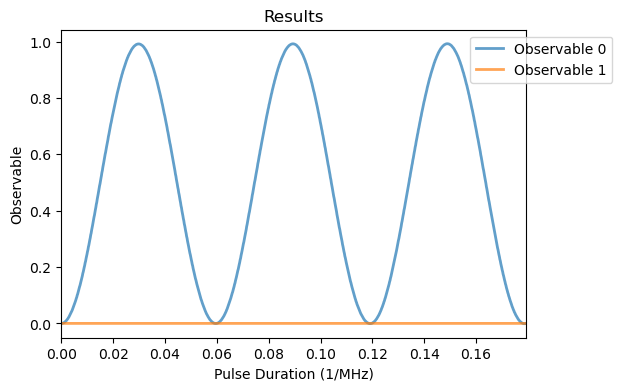

In [8]:
rabi_sim_2 = Rabi(
    pulse_duration = np.linspace(0, 3/w1, 1000),
    system = qsys_1,
    h1 = w1*qsys_1.MW_h1,
    # MW frequency for the ms=0 --> ms=+1 state transition
    pulse_params = {'f_pulse': qsys_1.MW_freqs[1]} 
)

rabi_sim_2.run()
rabi_analysis_2 = Analysis(rabi_sim_2)
rabi_analysis_2.plot_results()

Finally, by running a fit of the observable we can extract the $\pi$-pulse duration.

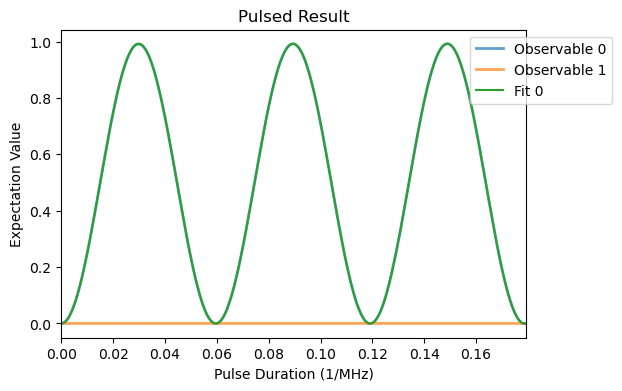

In [9]:
rabi_analysis_2.run_fit(
    fit_model = RabiModel(),
    # since there are two observables, we need to specify which one we want to fit
    results_index = 0
    )

rabi_analysis_2.plot_fit()
rabi_analysis_2.fit_params[0]

As expected the $\pi$-pulse duration is very close to $1/(2\omega_1)$.

# 3. Ramsey Experiment

## 3.1 Lab Frame

A simple, but important, pulse sequence in quantum sensing is the Ramsey experiment. It measures the accumulated phase difference in the two levels, by applying a $\pi/2$ pulse, waiting for a time $\tau$ and applying another $\pi/2$ pulse, then measuring the population in the $m_s=0$ state.

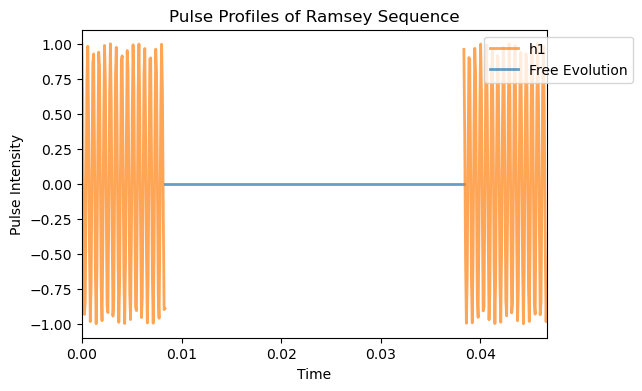

In [10]:
# NV center system same as before with standard observables
qsys_2 = NV(
    N=15,
    B0 = 40,
    units_B0='mT'
)

# Rabi frequency in MHz
w1 = 30 

ramsey_sim = Ramsey(
    # free evolution time in us
    free_duration = np.linspace(1/2/w1, 3, 500), 
    system = qsys_2,
    pi_pulse_duration = 1/2/w1,
    h1 = w1*qsys_2.MW_h1,
    pulse_params = {'f_pulse': qsys_2.MW_freqs[0]}
)

ramsey_sim.plot_pulses(tau=.03)

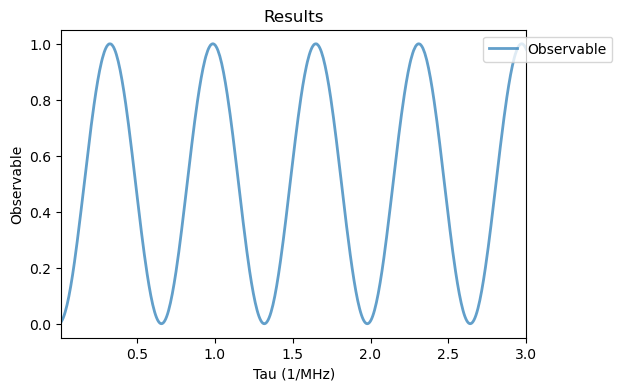

In [11]:
ramsey_sim.run()
Analysis(ramsey_sim).plot_results()

We could fit the results again with a period oscillation, but to illustrate a different method we will use the FFT from quaccatoo. First, the FFT is run with `run_FFT` method, then the peaks are found with `get_peaks_FFT`.

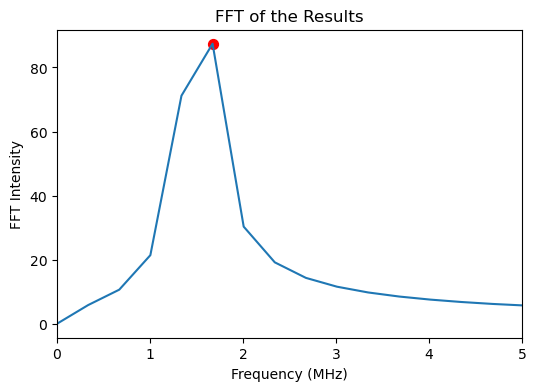

In [12]:
ramsey_analysis = Analysis(ramsey_sim)

ramsey_analysis.run_FFT()
ramsey_analysis.get_peaks_FFT()
ramsey_analysis.plot_FFT(freq_lim=[0,5])

The frequencies are too spaced in the FFT due to the short range of $\tau$, but we can see the main peak corresponds to approximately half of the hyperfine splitting of the nuclear spin $a_{||}/2=1.515$ MHz, as expected.

## 3.2 Rotating Frame

Let's now try to simulate the same sequence with delta pulses through the rotation operator of
$$\hat{R}_x = \begin{pmatrix}
1 & 0 \\
0 & \hat{\sigma}_x \\
\end{pmatrix} = 
\begin{pmatrix}
1 & 0 & 0\\
0 & 0 & 1\\
0 & 1 & 0
\end{pmatrix},
$$
which can be obtained through the `MW_Rx` attribute of the `NV` class. As in the previous tutorial, the simulation with delta pulses can be defined by setting `pi_pulse_duration = 0`.

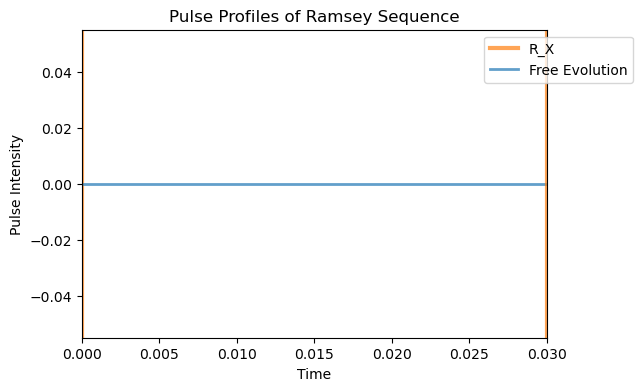

In [13]:
ramsey_delta_sim = Ramsey(
    free_duration = np.linspace(0, 3, 1000), 
    system = qsys_2,
    pi_pulse_duration = 0,
    Rx = qsys_2.MW_Rx[0],
)

ramsey_delta_sim.plot_pulses(tau=.03)

In this case then, the delta pulses appear as vertical lines.

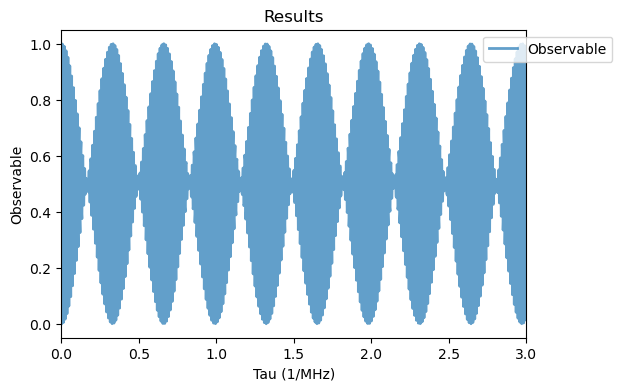

In [14]:
ramsey_delta_sim.run()
Analysis(ramsey_delta_sim).plot_results()

The expectation value of the observable presents fast modulations, contrary to the previous case. This is because that by adopting delta pulses we are also assuming the rotating frame. Thus, the Hamiltonian $\hat{H}_0$ needs to be modified accordingly. For that, we make a new quantum system, without the electronic terms and the perpendicular terms of the Hyperfine interaction.

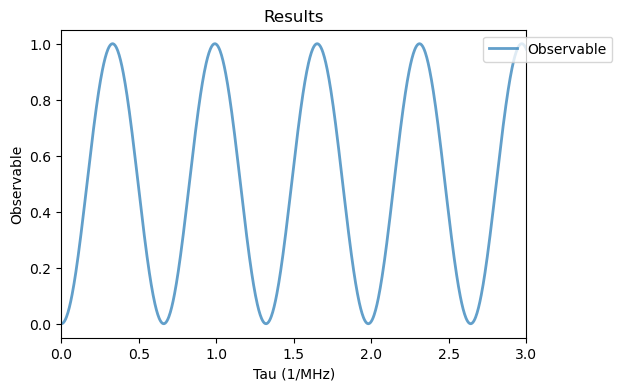

In [15]:
qsys_3 = copy.copy(qsys_2)
qsys_3.H0 = (
            3.03 * tensor(jmat(1, "z"), jmat(1 / 2, "z"))
            + qsys_3.nuclear_zeeman()
        )

ramsey_delta_sim_2 = Ramsey(
    free_duration = np.linspace(0, 3, 1000), 
    system = qsys_3,
    pi_pulse_duration = 0,
    Rx = qsys_3.MW_Rx[0],
)

ramsey_delta_sim_2.run()
Analysis(ramsey_delta_sim_2).plot_results()

Where we not obtain the results from the laboratory frame.

# 4. Pulsed Optically Detected Magnetic Resonance (pODMR)

To further study the energy levels of the system, we simulate a pODMR experiment. A pODMR experiment is simply composed by a pulse of varying frequency, thus when it corresponds to a resonance, a change in the observable is expected.

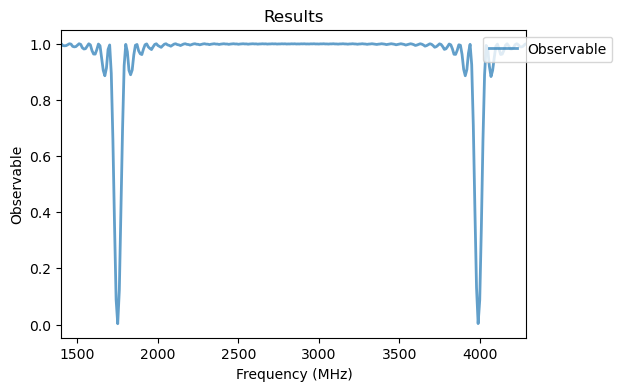

In [16]:
podmr_sim_1 = PMR(
    # frequencies to scan in MHz
    frequencies = np.arange(1400, 4300, 10), 
    system = qsys_2,
    pulse_duration = 1/2/w1,
    h1 = w1*qsys_2.MW_h1
)

podmr_sim_1.run()
Analysis(podmr_sim_1).plot_results()

Two resonances can be observed, corresponding to the two electronic spin transitions and with a splitting given by the Zeeman interaction with the external magnetic field. To see the nuclear spin splitting, we need to reduce the Rabi frequency to have a better spectral resolution.

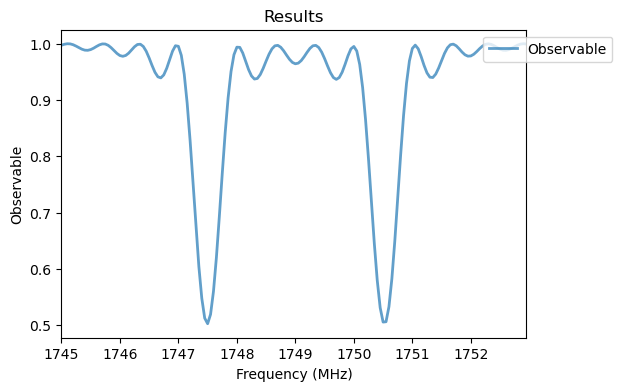

In [17]:
w1 = 0.3

podmr_sim_2 = PMR(
    frequencies = np.arange(1745, 1753, 0.05),
    system = qsys_2,
    pulse_duration = 1/2/w1,
    h1 = w1*qsys_2.MW_h1,
)

podmr_sim_2.run()
Analysis(podmr_sim_2).plot_results()

The two resonances now correspond to the two nuclear spin transitions. To get the splitting, we can fit them with Lorentzian Functions.

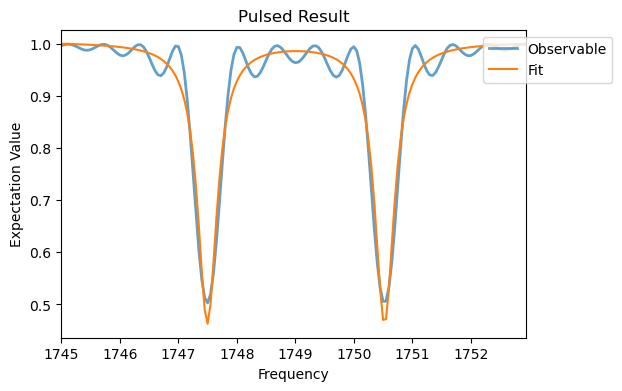

In [18]:
podmr_analysis_1 = Analysis(podmr_sim_2)

podmr_analysis_1.run_fit(
    fit_model = Model(fit_two_lorentz_sym),
    # initial guess for the fit parameters
    guess = {'A': 0.5, 'gamma': 0.2, 'f_mean':1749, 'f_delta':3,'C':1}, 
    )

podmr_analysis_1.plot_fit(xlabel='Frequency')
podmr_analysis_1.fit_params

From the fit we can extract the parallel component of the hyperfine splitting $a_{||}^n=3.03$ MHz. However, the commonly used Lorentzian function does not completely describes all features of the resonace. A better fit is provided with a sinc function.

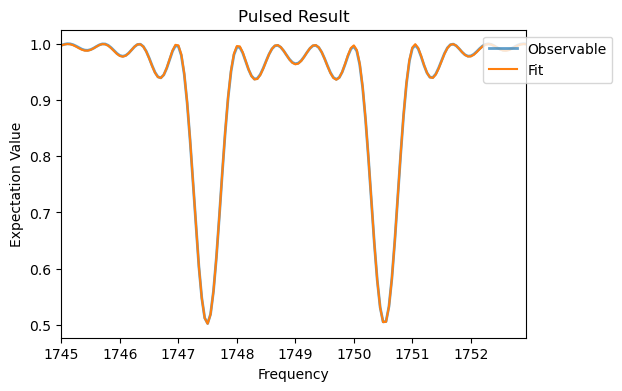

In [19]:
podmr_analysis_2 = Analysis(podmr_sim_2)

podmr_analysis_2.run_fit(
    fit_model = Model(fit_two_sinc2_sym),
    guess = {'A': 0.5, 'gamma': 0.4, 'f_mean':1749, 'f_delta':3,'C':1},
    )

podmr_analysis_2.plot_fit(xlabel='Frequency')
podmr_analysis_2.fit_params